# Preliminary Data Analysis - Pushup IMU Data
This notebook performs preliminary analysis on the collected pushup IMU sensor data.

## Dataset Overview
- **Data Type**: IMU sensor readings (accelerometer + gyroscope)
- **Format**: JSON files with session-based structure
- **Sample Rate**: 40 Hz
- **Sensor Placement**: Sternum
- **Labels**: Phase (top/bottom) and Posture (full-rom/partial-rom)

In [39]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import glob

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [40]:
# Load all JSON files from the raw dataset directory, but only want files collected from 12/04/25
data_files = glob.glob('raw_dataset/pushup_data_20251204*.json')
print(f"Found {len(data_files)} data files")

# Function to load and parse JSON data
def load_json_data(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load all files
all_data = [load_json_data(f) for f in data_files]
print(f"Loaded {len(all_data)} files successfully")

Found 16 data files
Loaded 16 files successfully


## 2. Convert to DataFrame

In [41]:
# Convert all sessions to a unified DataFrame
def extract_sessions(data_dict, file_index, filename):
    sessions = []
    for session in data_dict['sessions']:
        # Create unique session ID by combining file index and original session ID
        unique_session_id = f"{file_index}_{session['session_id']}"
        
        # Extract session metadata
        session_info = {
            'unique_session_id': unique_session_id,
            'original_session_id': session['session_id'],
            'file_index': file_index,
            'filename': filename,
            'timestamp': session['timestamp'],
            'participant_id': session.get('participant_id', ''),
            'imu_placement': session.get('imu_placement', ''),
            'phase_label': session.get('phase_label', ''),
            'posture_label': session.get('posture_label', ''),
            'sample_count': session['sample_count'],
            'duration_sec': session['duration_sec']
        }
        
        # Extract sensor data with sample index
        for sample_idx, data_point in enumerate(session['data']):
            row = session_info.copy()
            row.update({
                'sample_index': sample_idx,  # Use sample index instead of elapsed_sec
                'time_sec': sample_idx / 40.0,  # Calculate time from sample index (40 Hz)
                'ax': data_point['ax'],
                'ay': data_point['ay'],
                'az': data_point['az'],
                'gx': data_point['gx'],
                'gy': data_point['gy'],
                'gz': data_point['gz']
            })
            sessions.append(row)
    return sessions

# Extract all sessions from all files with unique IDs
all_sessions = []
for file_idx, (data, filename) in enumerate(zip(all_data, data_files)):
    all_sessions.extend(extract_sessions(data, file_idx, Path(filename).name))

# Create DataFrame
df = pd.DataFrame(all_sessions)
print(f"Total data points: {len(df)}")
print(f"\nDataFrame shape: {df.shape}")
print(f"Unique sessions: {df['unique_session_id'].nunique()}")
df

Total data points: 22880

DataFrame shape: (22880, 19)
Unique sessions: 277


,unique_session_id,original_session_id,file_index,filename,timestamp,participant_id,imu_placement,phase_label,posture_label,sample_count,duration_sec,sample_index,time_sec,ax,ay,az,gx,gy,gz
0,0_0,0,0,pushup_data_20251204_181925.json,2025-12-04T18:18:47.850497,,Sternum,top,good-form,84,2.102202,0,0.000,0.376953,0.188721,0.946533,1.740458,-0.908397,6.748092
1,0_0,0,0,pushup_data_20251204_181925.json,2025-12-04T18:18:47.850497,,Sternum,top,good-form,84,2.102202,1,0.025,0.379150,0.216553,1.035156,10.534351,-3.022901,4.885496
2,0_0,0,0,pushup_data_20251204_181925.json,2025-12-04T18:18:47.850497,,Sternum,top,good-form,84,2.102202,2,0.050,0.334717,0.197510,0.992676,21.931297,-3.687023,1.625954
3,0_0,0,0,pushup_data_20251204_181925.json,2025-12-04T18:18:47.850497,,Sternum,top,good-form,84,2.102202,3,0.075,0.333496,0.234619,0.918701,25.595419,4.610687,0.984733
4,0_0,0,0,pushup_data_20251204_181925.json,2025-12-04T18:18:47.850497,,Sternum,top,good-form,84,2.102202,4,0.100,0.349609,0.203857,0.828369,28.076336,3.381679,0.183206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22875,15_14,14,15,pushup_data_20251204_182238.json,2025-12-04T18:22:29.011256,,Sternum,top,good-form,77,1.919581,72,1.800,0.329102,-0.048584,0.853760,8.755725,5.580153,0.458015
22876,15_14,14,15,pushup_data_20251204_182238.json,2025-12-04T18:22:29.011256,,Sternum,top,good-form,77,1.919581,73,1.825,0.402832,-0.012695,0.732178,0.709924,13.160305,3.694656
22877,15_14,14,15,pushup_data_20251204_182238.json,2025-12-04T18:22:29.011256,,Sternum,top,good-form,77,1.919581,74,1.850,0.434814,0.064209,0.898926,3.083969,-2.625954,1.847328
22878,15_14,14,15,pushup_data_20251204_182238.json,2025-12-04T18:22:29.011256,,Sternum,top,good-form,77,1.919581,75,1.875,0.336182,-0.003906,1.064209,4.305344,-13.427481,-0.961832


## 3. Basic Statistics

In [42]:
# Display basic information
print("Raw Dataset Info:")
print(df.info())
print("\n" + "="*50 + "\n")

# Summary statistics for sensor data
print("Sensor Data Statistics:")
print(df[['ax', 'ay', 'az', 'gx', 'gy', 'gz']].describe())

Raw Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22880 entries, 0 to 22879
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   unique_session_id    22880 non-null  object 
 1   original_session_id  22880 non-null  int64  
 2   file_index           22880 non-null  int64  
 3   filename             22880 non-null  object 
 4   timestamp            22880 non-null  object 
 5   participant_id       22880 non-null  object 
 6   imu_placement        22880 non-null  object 
 7   phase_label          22880 non-null  object 
 8   posture_label        22880 non-null  object 
 9   sample_count         22880 non-null  int64  
 10  duration_sec         22880 non-null  float64
 11  sample_index         22880 non-null  int64  
 12  time_sec             22880 non-null  float64
 13  ax                   22880 non-null  float64
 14  ay                   22880 non-null  float64
 15  az                

In [43]:
# Count unique sessions
unique_sessions = df.groupby(['timestamp', 'unique_session_id']).size().reset_index(name='count')
print(f"Total unique sessions: {len(unique_sessions)}")

# Label distribution
print("\nPhase Label Distribution:")
print(df.groupby('phase_label')['unique_session_id'].nunique())

print("\nPosture Label Distribution:")
print(df.groupby('posture_label')['unique_session_id'].nunique())

Total unique sessions: 277

Phase Label Distribution:
phase_label
top    277
Name: unique_session_id, dtype: int64

Posture Label Distribution:
posture_label
good-form       155
hips-high        41
hips-sagging     40
partial-rom      41
Name: unique_session_id, dtype: int64


## 4. Data Visualization

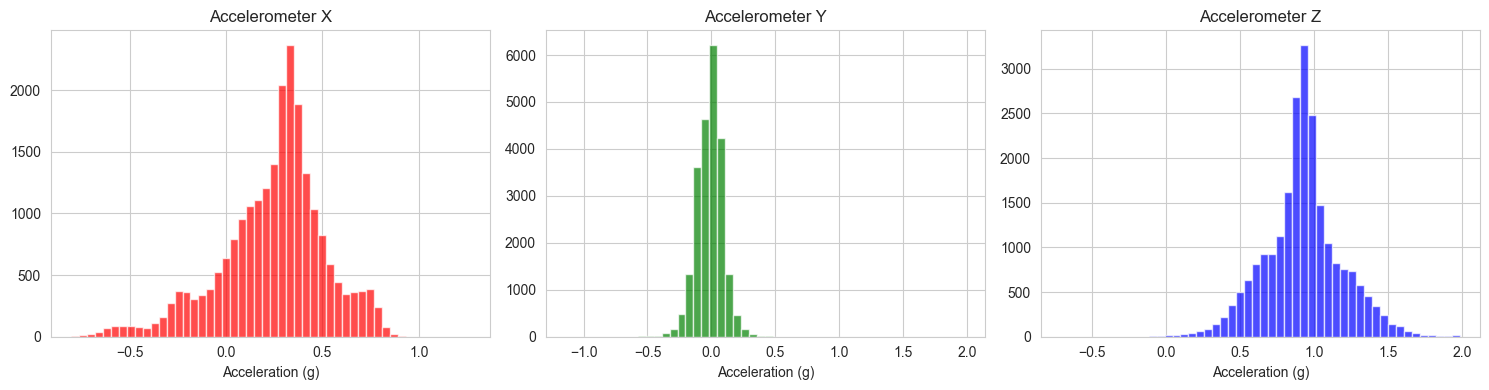

In [44]:
# Plot accelerometer data distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['ax'], bins=50, alpha=0.7, color='red')
axes[0].set_title('Accelerometer X')
axes[0].set_xlabel('Acceleration (g)')

axes[1].hist(df['ay'], bins=50, alpha=0.7, color='green')
axes[1].set_title('Accelerometer Y')
axes[1].set_xlabel('Acceleration (g)')

axes[2].hist(df['az'], bins=50, alpha=0.7, color='blue')
axes[2].set_title('Accelerometer Z')
axes[2].set_xlabel('Acceleration (g)')

plt.tight_layout()
plt.show()

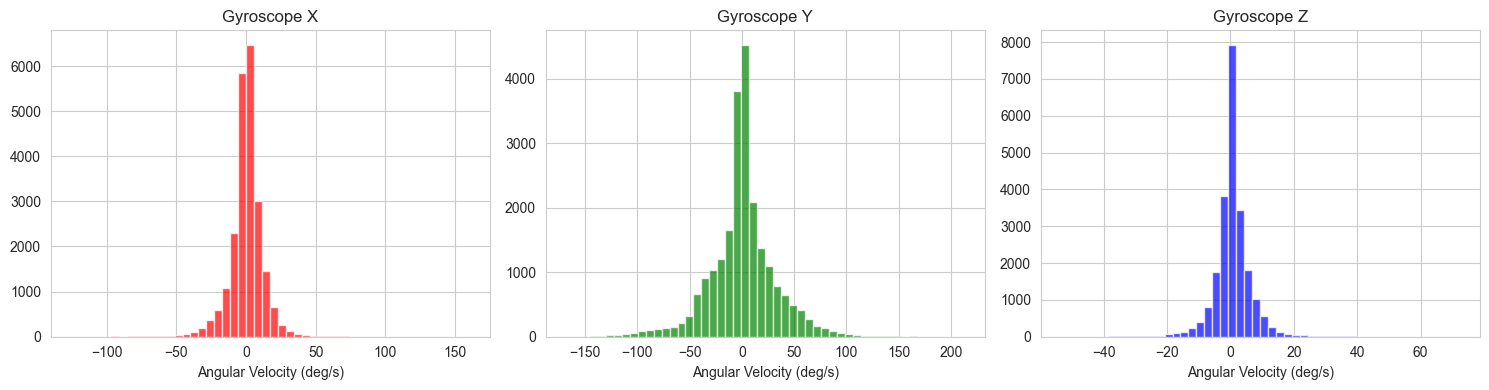

In [45]:
# Plot gyroscope data distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['gx'], bins=50, alpha=0.7, color='red')
axes[0].set_title('Gyroscope X')
axes[0].set_xlabel('Angular Velocity (deg/s)')

axes[1].hist(df['gy'], bins=50, alpha=0.7, color='green')
axes[1].set_title('Gyroscope Y')
axes[1].set_xlabel('Angular Velocity (deg/s)')

axes[2].hist(df['gz'], bins=50, alpha=0.7, color='blue')
axes[2].set_title('Gyroscope Z')
axes[2].set_xlabel('Angular Velocity (deg/s)')

plt.tight_layout()
plt.show()

## 5. Sample Session Analysis

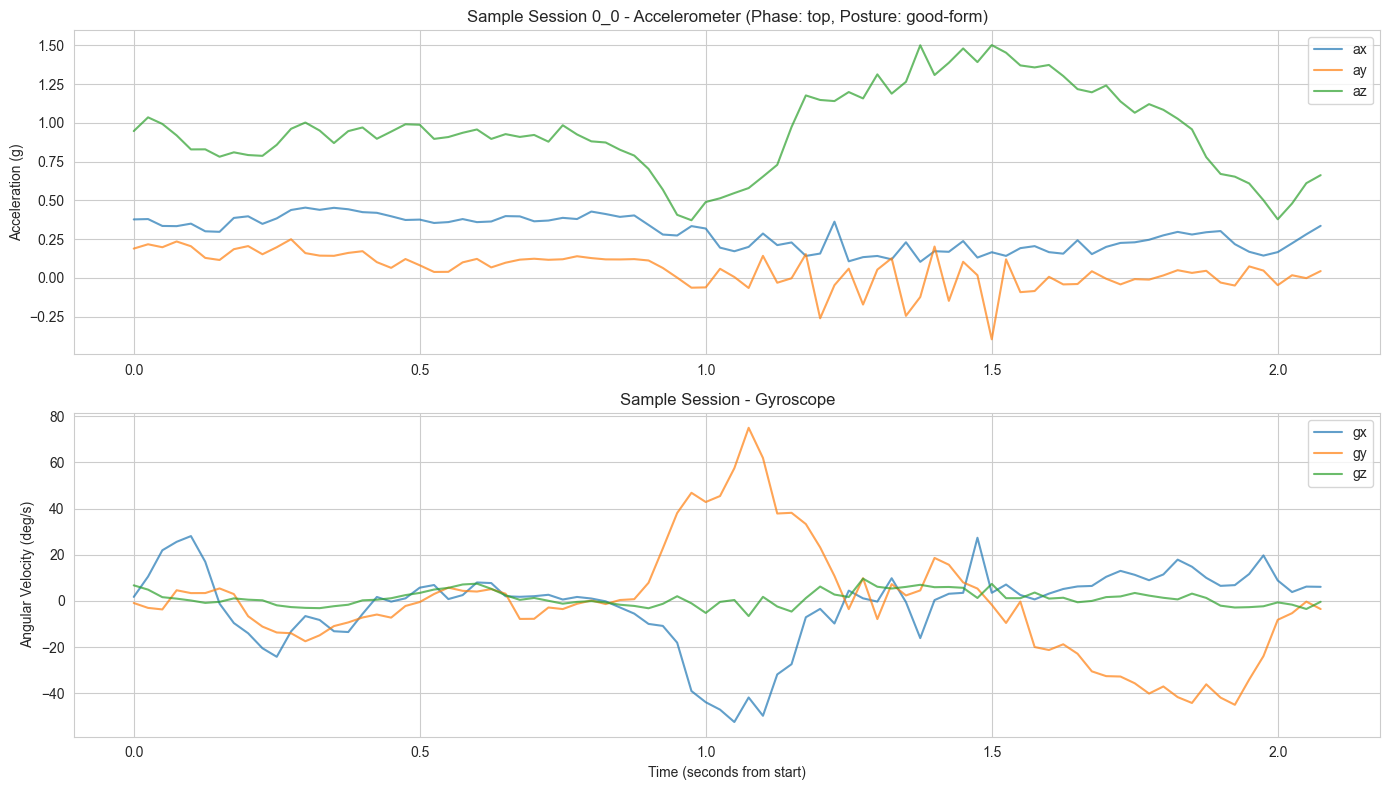

In [46]:
# Plot a sample session
# Use the first unique session ID
first_session_id = df['unique_session_id'].iloc[15]
sample_session = df[df['unique_session_id'] == first_session_id].copy()
sample_session = sample_session.sort_values('sample_index')

# Use time calculated from sample index
time_from_start = sample_session['time_sec']

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Accelerometer
axes[0].plot(time_from_start, sample_session['ax'], label='ax', alpha=0.7)
axes[0].plot(time_from_start, sample_session['ay'], label='ay', alpha=0.7)
axes[0].plot(time_from_start, sample_session['az'], label='az', alpha=0.7)
axes[0].set_title(f'Sample Session {first_session_id} - Accelerometer (Phase: {sample_session["phase_label"].iloc[0]}, Posture: {sample_session["posture_label"].iloc[0]})')
axes[0].set_ylabel('Acceleration (g)')
axes[0].legend()
axes[0].grid(True)

# Gyroscope
axes[1].plot(time_from_start, sample_session['gx'], label='gx', alpha=0.7)
axes[1].plot(time_from_start, sample_session['gy'], label='gy', alpha=0.7)
axes[1].plot(time_from_start, sample_session['gz'], label='gz', alpha=0.7)
axes[1].set_title('Sample Session - Gyroscope')
axes[1].set_xlabel('Time (seconds from start)')
axes[1].set_ylabel('Angular Velocity (deg/s)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 6. Compare Different Labels

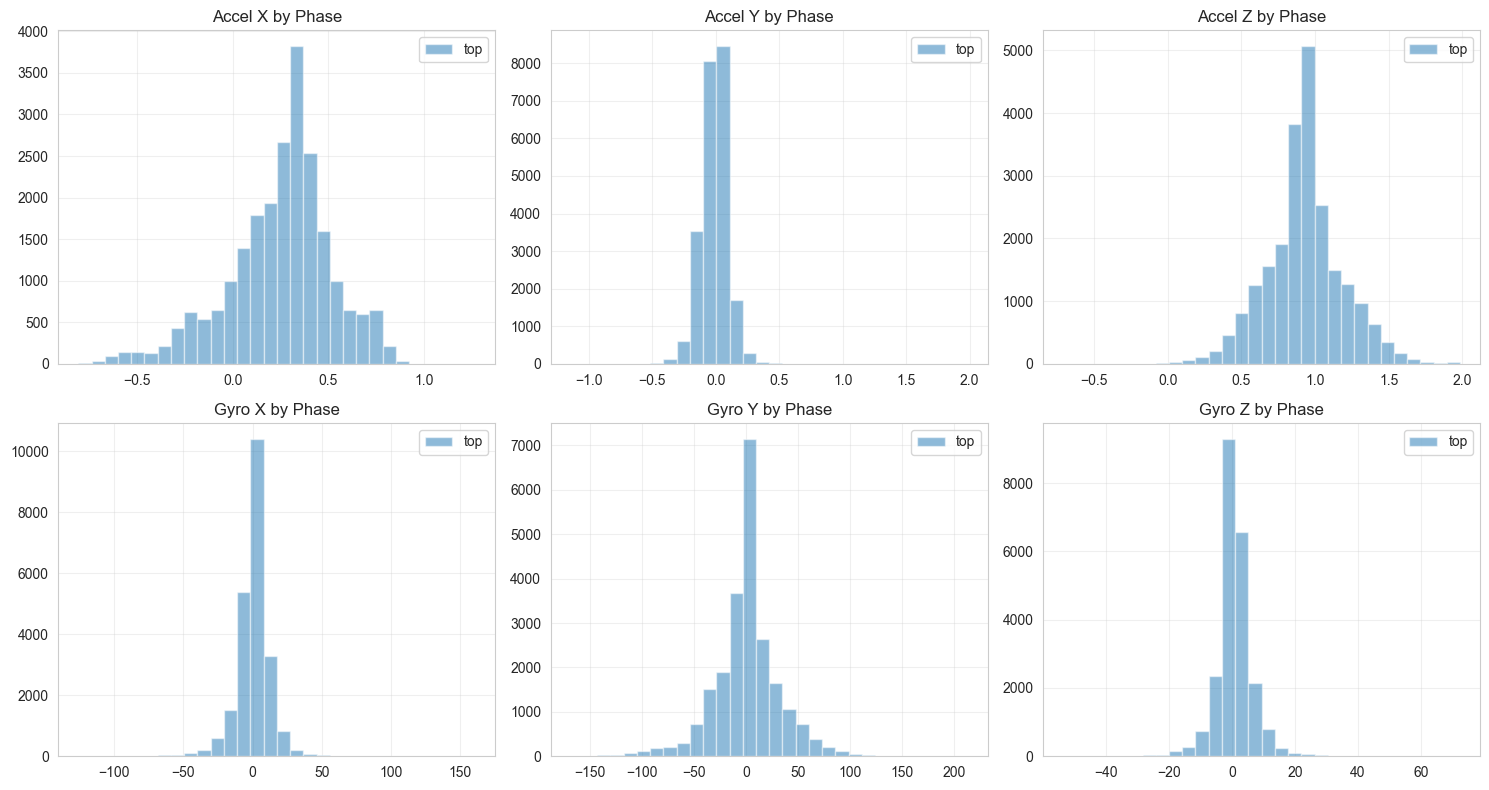

In [47]:
# Compare phase labels (top vs bottom)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for phase in df['phase_label'].unique():
    if pd.notna(phase) and phase != '':
        phase_data = df[df['phase_label'] == phase]
        
        # Accelerometer
        axes[0, 0].hist(phase_data['ax'], bins=30, alpha=0.5, label=phase)
        axes[0, 1].hist(phase_data['ay'], bins=30, alpha=0.5, label=phase)
        axes[0, 2].hist(phase_data['az'], bins=30, alpha=0.5, label=phase)
        
        # Gyroscope
        axes[1, 0].hist(phase_data['gx'], bins=30, alpha=0.5, label=phase)
        axes[1, 1].hist(phase_data['gy'], bins=30, alpha=0.5, label=phase)
        axes[1, 2].hist(phase_data['gz'], bins=30, alpha=0.5, label=phase)

axes[0, 0].set_title('Accel X by Phase')
axes[0, 1].set_title('Accel Y by Phase')
axes[0, 2].set_title('Accel Z by Phase')
axes[1, 0].set_title('Gyro X by Phase')
axes[1, 1].set_title('Gyro Y by Phase')
axes[1, 2].set_title('Gyro Z by Phase')

for ax in axes.flat:
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

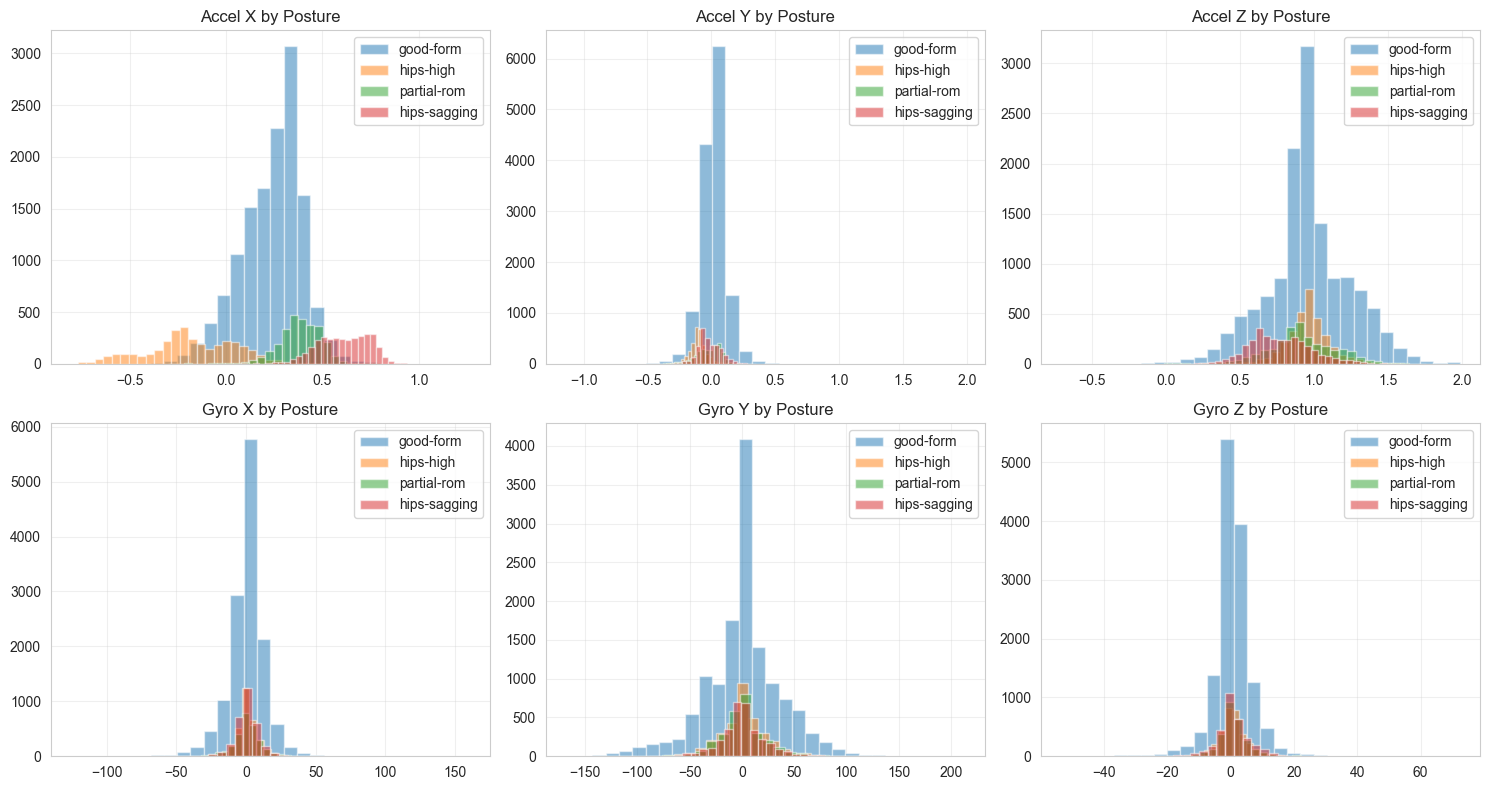

In [48]:
# Compare posture labels (full-rom vs partial-rom)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for posture in df['posture_label'].unique():
    if pd.notna(posture) and posture != '':
        posture_data = df[df['posture_label'] == posture]
        
        # Accelerometer
        axes[0, 0].hist(posture_data['ax'], bins=30, alpha=0.5, label=posture)
        axes[0, 1].hist(posture_data['ay'], bins=30, alpha=0.5, label=posture)
        axes[0, 2].hist(posture_data['az'], bins=30, alpha=0.5, label=posture)
        
        # Gyroscope
        axes[1, 0].hist(posture_data['gx'], bins=30, alpha=0.5, label=posture)
        axes[1, 1].hist(posture_data['gy'], bins=30, alpha=0.5, label=posture)
        axes[1, 2].hist(posture_data['gz'], bins=30, alpha=0.5, label=posture)

axes[0, 0].set_title('Accel X by Posture')
axes[0, 1].set_title('Accel Y by Posture')
axes[0, 2].set_title('Accel Z by Posture')
axes[1, 0].set_title('Gyro X by Posture')
axes[1, 1].set_title('Gyro Y by Posture')
axes[1, 2].set_title('Gyro Z by Posture')

for ax in axes.flat:
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Engineering

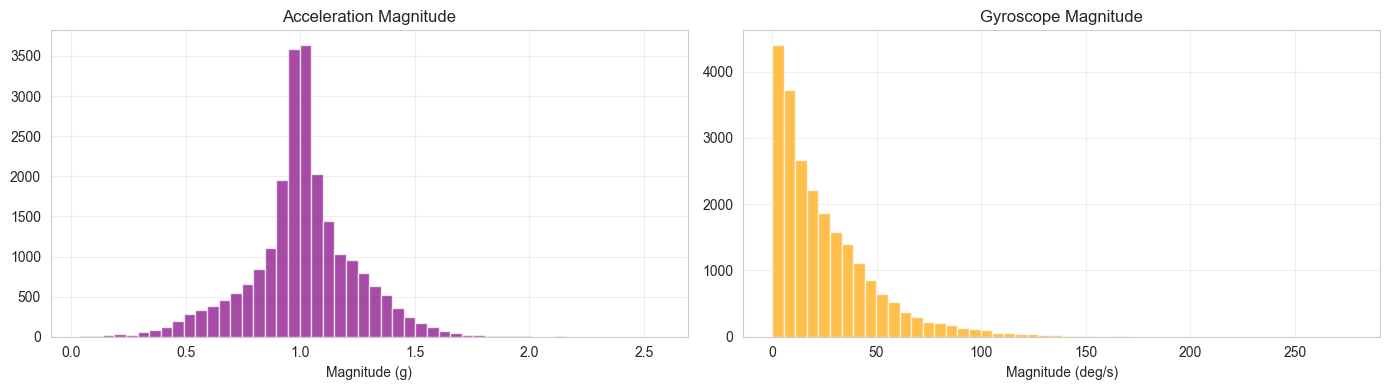

In [49]:
# Calculate magnitude features
df['accel_magnitude'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2)
df['gyro_magnitude'] = np.sqrt(df['gx']**2 + df['gy']**2 + df['gz']**2)

# Plot magnitude distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(df['accel_magnitude'], bins=50, alpha=0.7, color='purple')
axes[0].set_title('Acceleration Magnitude')
axes[0].set_xlabel('Magnitude (g)')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df['gyro_magnitude'], bins=50, alpha=0.7, color='orange')
axes[1].set_title('Gyroscope Magnitude')
axes[1].set_xlabel('Magnitude (deg/s)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Correlation Analysis

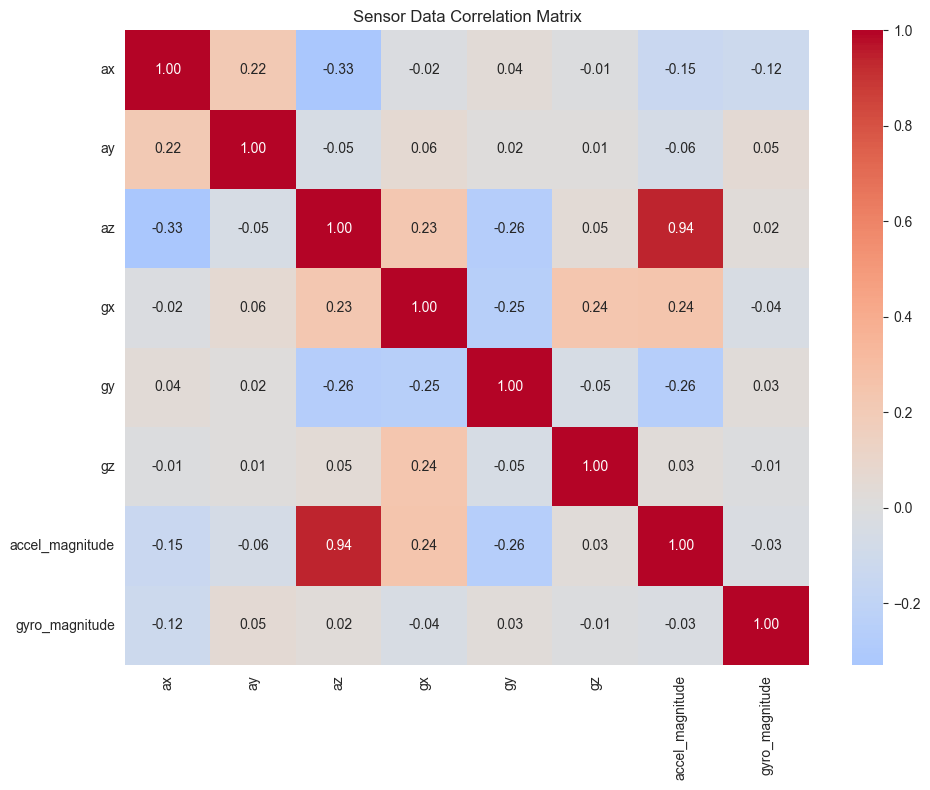

In [50]:
# Compute correlation matrix
sensor_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'accel_magnitude', 'gyro_magnitude']
corr_matrix = df[sensor_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Sensor Data Correlation Matrix')
plt.tight_layout()
plt.show()

## 9. Session Statistics Summary

In [51]:
# Aggregate statistics per session
session_stats = df.groupby(['unique_session_id', 'filename', 'timestamp', 'phase_label', 'posture_label']).agg({
    'ax': ['mean', 'std', 'min', 'max'],
    'ay': ['mean', 'std', 'min', 'max'],
    'az': ['mean', 'std', 'min', 'max'],
    'gx': ['mean', 'std', 'min', 'max'],
    'gy': ['mean', 'std', 'min', 'max'],
    'gz': ['mean', 'std', 'min', 'max'],
    'duration_sec': 'first',
    'sample_count': 'first'
}).reset_index()

print(f"Total sessions: {len(session_stats)}")
session_stats

Total sessions: 277


unique_session_id                          filename  \
                                                          
0                 0_0  pushup_data_20251204_181925.json   
1                 0_1  pushup_data_20251204_181925.json   
2                0_10  pushup_data_20251204_181925.json   
3                0_11  pushup_data_20251204_181925.json   
4                0_12  pushup_data_20251204_181925.json   
..                ...                               ...   
272               9_5  pushup_data_20251204_190149.json   
273               9_6  pushup_data_20251204_190149.json   
274               9_7  pushup_data_20251204_190149.json   
275               9_8  pushup_data_20251204_190149.json   
276               9_9  pushup_data_20251204_190149.json   

                      timestamp phase_label posture_label        ax            \
                                                               mean       std   
0    2025-12-04T18:18:47.850497         top     good-form  0.287920  0.101814   
1    2025-12-04T18:18:50.490484         top     good-form  0.285125  0.118578   
2    2025-12-04T18:19:13.530772         top     good-form  0.267410  0.119060   
3    2025-12-04T18:19:16.198788         top     good-form  0.253121  0.113979   
4    2025-12-04T18:19:18.720133         top     good-form  0.250936  0.127663   
..                          ...         ...           ...       ...       ...   
272  2025-12-04T19:01:00.346773         top  hips-sagging  0.508548  0.085623   
273  2025-12-04T19:01:02.926995         top  hips-sagging  0.480419  0.096188   
274  2025-12-04T19:01:05.775874         top  hips-sagging  0.496151  0.096373   
275  2025-12-04T19:01:08.656606         top  hips-sagging  0.504533  0.078024   
276  2025-12-04T19:01:11.325497         top  hips-sagging  0.482187  0.090043   

                               ay  ...        gy                        \
          min       max      mean  ...      mean        std        min   
0    0.103271  0.452881  0.053586  ... -1.098873  24.026315 -44.992367   
1   -0.042480  0.464111  0.030384  ...  0.667295  26.606698 -44.526718   
2    0.043701  0.442139  0.029671  ...  0.925548  25.804817 -40.221375   
3    0.015137  0.437988  0.022990  ...  0.659620  25.752049 -47.167938   
4    0.000732  0.453857  0.030762  ...  0.413388  26.360351 -45.221375   
..        ...       ...       ...  ...       ...        ...        ...   
272  0.249023  0.700439  0.029853  ...  3.430380  25.618508 -52.099236   
273  0.151367  0.689453  0.021557  ...  0.702600  27.545317 -52.938931   
274  0.247803  0.771240  0.025225  ...  1.137876  32.442484 -67.458015   
275  0.303467  0.752441  0.005347  ...  3.484214  26.197361 -59.366413   
276  0.326416  0.915527  0.059977  ... -3.587888  31.737989 -62.480915   

                       gz                                 duration_sec  \
            max      mean       std        min        max        first   
0     74.977097  1.143584  3.294912  -6.564886   9.641221     2.102202   
1     67.022903  0.253792  2.282884  -4.503817   8.908397     1.921325   
2     65.221375  0.347180  2.713028  -8.022901   8.969465     1.921136   
3     56.358780  0.443433  2.652161  -6.725191  10.664123     1.949721   
4     66.106873  0.417596  2.686870  -6.572519   8.503817     1.949723   
..          ...       ...       ...        ...        ...          ...   
272   62.954197  1.185622  6.506478 -12.251908  14.984733     1.981797   
273   76.435112  0.684547  7.929090 -12.824428  23.137405     1.831433   
274   81.496185  0.397700  8.558200 -23.114504  19.038168     2.008907   
275   65.114502 -0.717934  8.319142 -16.625954  23.748091     2.011019   
276  152.000000  2.036336  7.127294 -16.175573  18.587786     1.860082   

    sample_count  
           first  
0             84  
1             77  
2             77  
3             78  
4             78  
..           ...  
272           79  
273           74  
274           81  
275           81  
276           75  

[277 row

## 10. Data Quality Checks

In [52]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50 + "\n")

# Check for outliers (values beyond 3 standard deviations)
print("Potential Outliers (beyond 3 std):")
for col in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
    mean = df[col].mean()
    std = df[col].std()
    outliers = df[(df[col] < mean - 3*std) | (df[col] > mean + 3*std)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")

Missing Values:
unique_session_id      0
original_session_id    0
file_index             0
filename               0
timestamp              0
participant_id         0
imu_placement          0
phase_label            0
posture_label          0
sample_count           0
duration_sec           0
sample_index           0
time_sec               0
ax                     0
ay                     0
az                     0
gx                     0
gy                     0
gz                     0
accel_magnitude        0
gyro_magnitude         0
dtype: int64


Potential Outliers (beyond 3 std):
ax: 216 outliers (0.94%)
ay: 210 outliers (0.92%)
az: 158 outliers (0.69%)
gx: 382 outliers (1.67%)
gy: 378 outliers (1.65%)
gz: 423 outliers (1.85%)


## 11. Export Summary
Save the processed data for further analysis or model training.

In [53]:
# Save processed DataFrame
# df.to_csv('processed_pushup_data.csv', index=False)
# print("Processed data saved to 'processed_pushup_data.csv'")

# Save session statistics
# session_stats.to_csv('session_statistics.csv', index=False)
# print("Session statistics saved to 'session_statistics.csv'")

## 12. 3D Position Tracking via Double Integration

Integrate accelerometer data twice to estimate the 3D position of the chest during push-ups.

**Method:**
1. Remove gravity from accelerometer readings
2. First integration: acceleration → velocity
3. Second integration: velocity → position

**Important Notes:**
- This is a simple integration that assumes the sensor frame doesn't rotate significantly
- IMU drift will cause position estimates to drift over time (common in inertial navigation)
- For more accurate results, sensor fusion with gyroscope data would be needed
- Best used for short-duration movements (1-2 seconds)

In [54]:
def integrate_position(session_data, sample_rate_hz=40):
    """
    Integrate accelerometer data twice to estimate position.
    
    Parameters:
    - session_data: DataFrame with columns ['time_sec', 'ax', 'ay', 'az']
    - sample_rate_hz: Sample rate in Hz (default 40)
    
    Returns:
    - DataFrame with velocity and position columns added
    """
    # Make a copy
    data = session_data.copy()
    
    # Gravity constant in g's (1g = 9.81 m/s^2)
    GRAVITY_G = 1.0
    
    # Estimate static gravity direction (average of first few samples)
    # Assuming sensor is relatively still at the start
    n_samples_for_gravity = min(10, len(data))
    gravity_x = data['ax'].iloc[:n_samples_for_gravity].mean()
    gravity_y = data['ay'].iloc[:n_samples_for_gravity].mean()
    gravity_z = data['az'].iloc[:n_samples_for_gravity].mean()
    
    print(f"Estimated gravity vector: ({gravity_x:.3f}, {gravity_y:.3f}, {gravity_z:.3f}) g")
    
    # Remove gravity from accelerometer readings
    data['ax_nograv'] = data['ax'] - gravity_x
    data['ay_nograv'] = data['ay'] - gravity_y
    data['az_nograv'] = data['az'] - gravity_z
    
    # Convert acceleration from g to m/s^2
    G_TO_MS2 = 9.81
    data['ax_ms2'] = data['ax_nograv'] * G_TO_MS2
    data['ay_ms2'] = data['ay_nograv'] * G_TO_MS2
    data['az_ms2'] = data['az_nograv'] * G_TO_MS2
    
    # Calculate time delta between samples
    dt = 1.0 / sample_rate_hz
    
    # First integration: acceleration → velocity (m/s)
    # Using cumulative trapezoidal integration
    data['vx'] = np.cumsum(data['ax_ms2']) * dt
    data['vy'] = np.cumsum(data['ay_ms2']) * dt
    data['vz'] = np.cumsum(data['az_ms2']) * dt
    
    # Second integration: velocity → position (m)
    data['px'] = np.cumsum(data['vx']) * dt
    data['py'] = np.cumsum(data['vy']) * dt
    data['pz'] = np.cumsum(data['vz']) * dt
    
    return data

# Select a sample session
sample_session_id = df['unique_session_id'].iloc[0]
sample_data = df[df['unique_session_id'] == sample_session_id].copy()
sample_data = sample_data.sort_values('sample_index').reset_index(drop=True)

print(f"Processing session: {sample_session_id}")
print(f"Posture: {sample_data['posture_label'].iloc[0]}")
print(f"Duration: {sample_data['duration_sec'].iloc[0]:.2f}s")
print(f"Samples: {len(sample_data)}\n")

# Integrate to get position
result = integrate_position(sample_data)

# Display results
print(f"\nFinal estimated position:")
print(f"  X: {result['px'].iloc[-1]:.3f} m")
print(f"  Y: {result['py'].iloc[-1]:.3f} m")
print(f"  Z: {result['pz'].iloc[-1]:.3f} m")
print(f"  Total displacement: {np.sqrt(result['px'].iloc[-1]**2 + result['py'].iloc[-1]**2 + result['pz'].iloc[-1]**2):.3f} m")

Processing session: 0_0
Posture: good-form
Duration: 2.10s
Samples: 84

Estimated gravity vector: (0.350, 0.183, 0.872) g

Final estimated position:
  X: -0.490 m
  Y: -1.974 m
  Z: 1.198 m
  Total displacement: 2.361 m


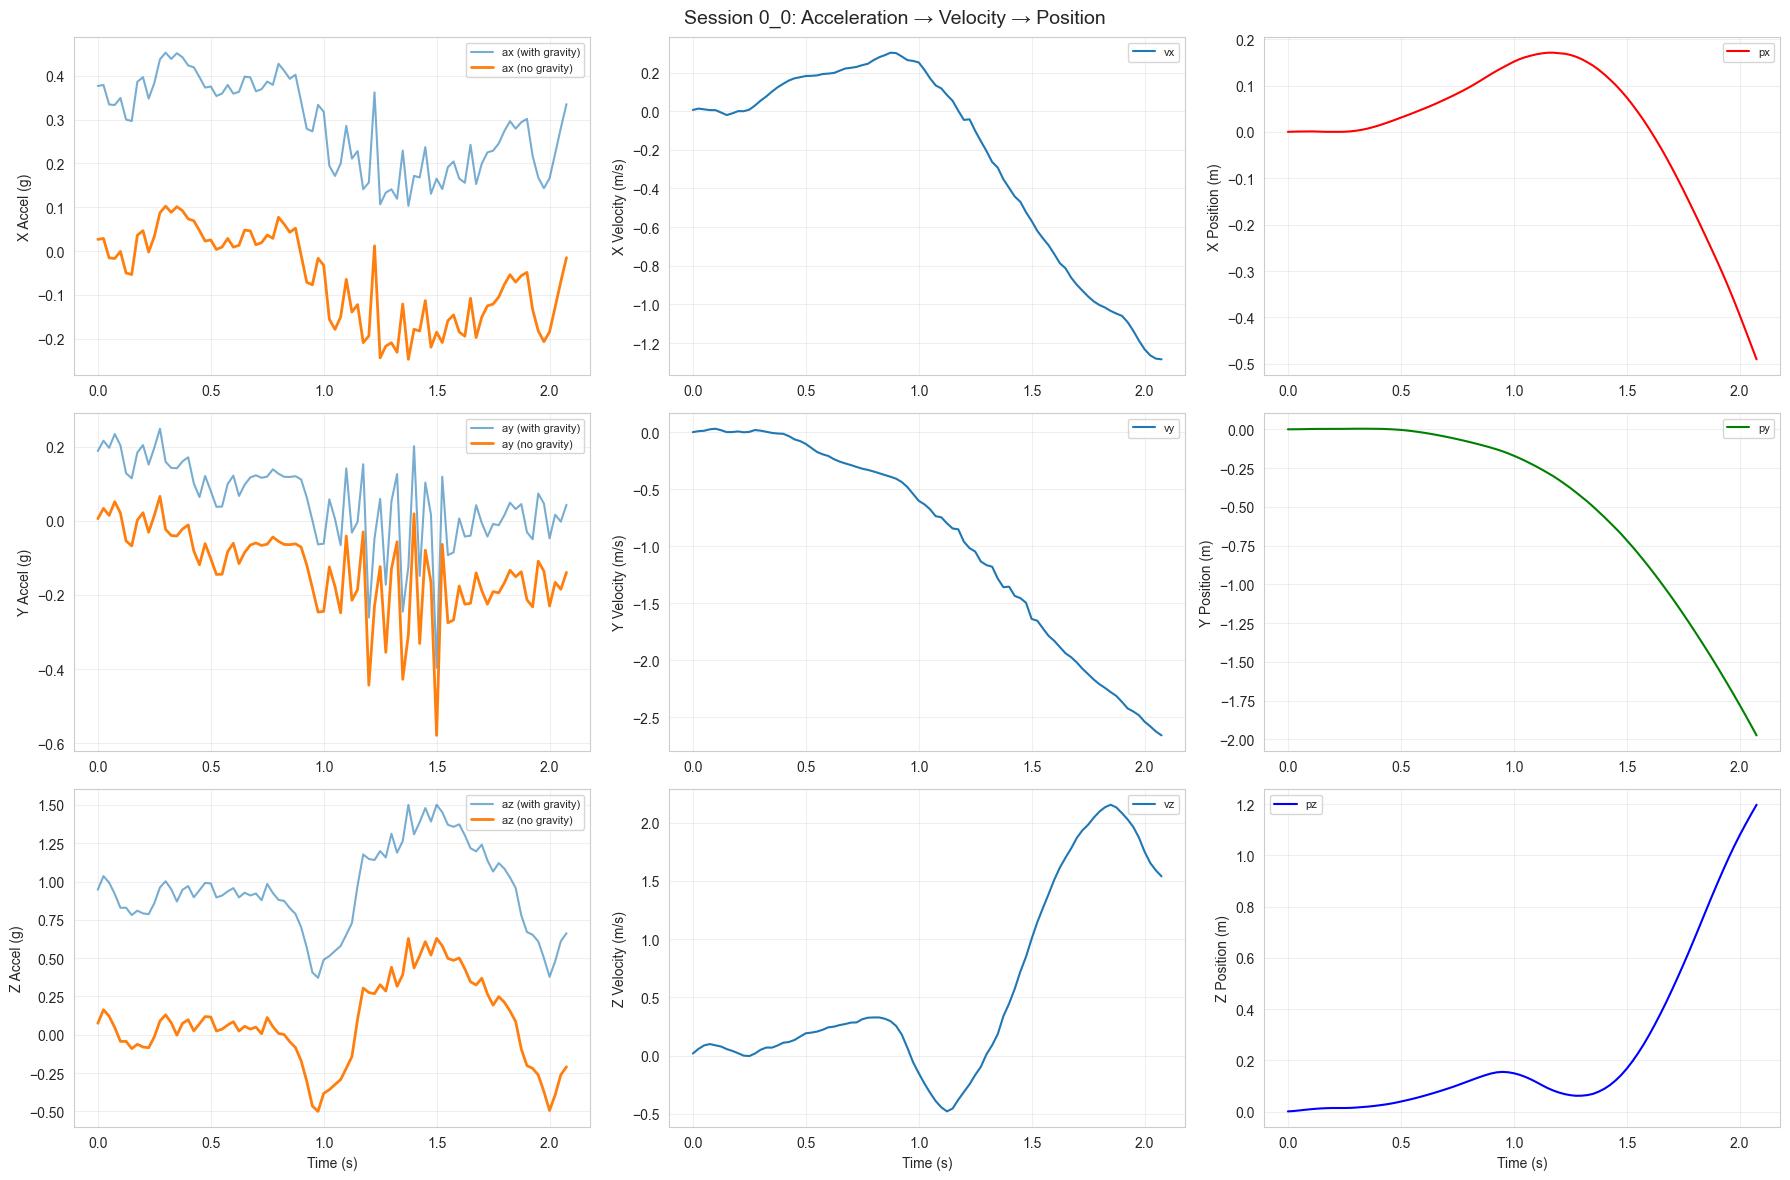

In [55]:
# Create comprehensive plots
fig = plt.figure(figsize=(18, 12))

# 1. Acceleration (with and without gravity)
ax1 = plt.subplot(3, 3, 1)
ax1.plot(result['time_sec'], result['ax'], label='ax (with gravity)', alpha=0.6)
ax1.plot(result['time_sec'], result['ax_nograv'], label='ax (no gravity)', linewidth=2)
ax1.set_ylabel('X Accel (g)')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 3, 4)
ax2.plot(result['time_sec'], result['ay'], label='ay (with gravity)', alpha=0.6)
ax2.plot(result['time_sec'], result['ay_nograv'], label='ay (no gravity)', linewidth=2)
ax2.set_ylabel('Y Accel (g)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(3, 3, 7)
ax3.plot(result['time_sec'], result['az'], label='az (with gravity)', alpha=0.6)
ax3.plot(result['time_sec'], result['az_nograv'], label='az (no gravity)', linewidth=2)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Z Accel (g)')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 2. Velocity
ax4 = plt.subplot(3, 3, 2)
ax4.plot(result['time_sec'], result['vx'], label='vx')
ax4.set_ylabel('X Velocity (m/s)')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(3, 3, 5)
ax5.plot(result['time_sec'], result['vy'], label='vy')
ax5.set_ylabel('Y Velocity (m/s)')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(3, 3, 8)
ax6.plot(result['time_sec'], result['vz'], label='vz')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Z Velocity (m/s)')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

# 3. Position
ax7 = plt.subplot(3, 3, 3)
ax7.plot(result['time_sec'], result['px'], label='px', color='red')
ax7.set_ylabel('X Position (m)')
ax7.legend(fontsize=8)
ax7.grid(True, alpha=0.3)

ax8 = plt.subplot(3, 3, 6)
ax8.plot(result['time_sec'], result['py'], label='py', color='green')
ax8.set_ylabel('Y Position (m)')
ax8.legend(fontsize=8)
ax8.grid(True, alpha=0.3)

ax9 = plt.subplot(3, 3, 9)
ax9.plot(result['time_sec'], result['pz'], label='pz', color='blue')
ax9.set_xlabel('Time (s)')
ax9.set_ylabel('Z Position (m)')
ax9.legend(fontsize=8)
ax9.grid(True, alpha=0.3)

plt.suptitle(f'Session {sample_session_id}: Acceleration → Velocity → Position', fontsize=14)
plt.tight_layout()
plt.show()

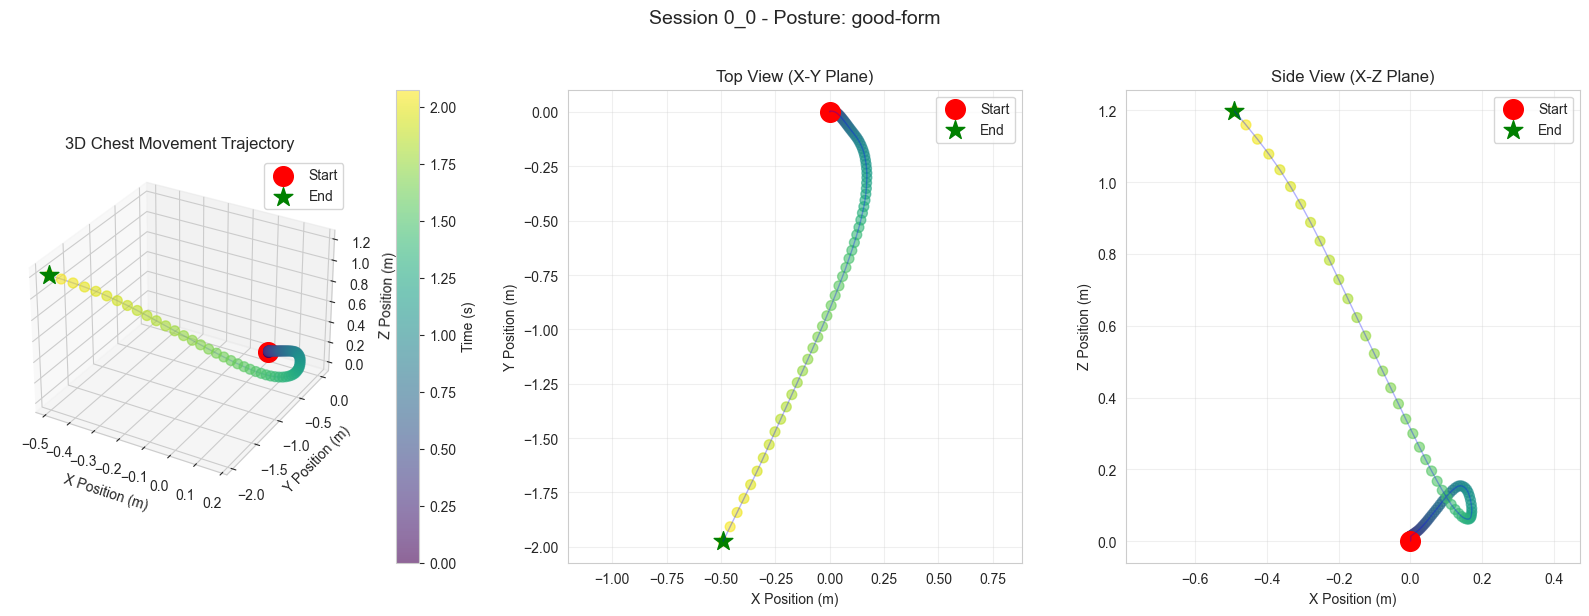

In [56]:
# Create 3D trajectory plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 6))

# 3D trajectory
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(result['px'], result['py'], result['pz'], 
                     c=result['time_sec'], cmap='viridis', 
                     s=50, alpha=0.6)
ax1.plot(result['px'], result['py'], result['pz'], 'b-', alpha=0.3, linewidth=1)
ax1.scatter([0], [0], [0], color='red', s=200, marker='o', label='Start')
ax1.scatter([result['px'].iloc[-1]], [result['py'].iloc[-1]], [result['pz'].iloc[-1]], 
           color='green', s=200, marker='*', label='End')
ax1.set_xlabel('X Position (m)')
ax1.set_ylabel('Y Position (m)')
ax1.set_zlabel('Z Position (m)')
ax1.set_title('3D Chest Movement Trajectory')
ax1.legend()
plt.colorbar(scatter, ax=ax1, label='Time (s)', pad=0.1)

# 2D projections
ax2 = fig.add_subplot(132)
scatter2 = ax2.scatter(result['px'], result['py'], c=result['time_sec'], 
                      cmap='viridis', s=50, alpha=0.6)
ax2.plot(result['px'], result['py'], 'b-', alpha=0.3, linewidth=1)
ax2.scatter([0], [0], color='red', s=200, marker='o', label='Start')
ax2.scatter([result['px'].iloc[-1]], [result['py'].iloc[-1]], 
           color='green', s=200, marker='*', label='End')
ax2.set_xlabel('X Position (m)')
ax2.set_ylabel('Y Position (m)')
ax2.set_title('Top View (X-Y Plane)')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')
ax2.legend()

# X-Z projection (side view)
ax3 = fig.add_subplot(133)
scatter3 = ax3.scatter(result['px'], result['pz'], c=result['time_sec'], 
                      cmap='viridis', s=50, alpha=0.6)
ax3.plot(result['px'], result['pz'], 'b-', alpha=0.3, linewidth=1)
ax3.scatter([0], [0], color='red', s=200, marker='o', label='Start')
ax3.scatter([result['px'].iloc[-1]], [result['pz'].iloc[-1]], 
           color='green', s=200, marker='*', label='End')
ax3.set_xlabel('X Position (m)')
ax3.set_ylabel('Z Position (m)')
ax3.set_title('Side View (X-Z Plane)')
ax3.grid(True, alpha=0.3)
ax3.axis('equal')
ax3.legend()

plt.suptitle(f'Session {sample_session_id} - Posture: {sample_data["posture_label"].iloc[0]}', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Compare Multiple Sessions

Let's visualize trajectories from different posture types to see if there are distinguishable patterns.

Estimated gravity vector: (0.350, 0.183, 0.872) g
Estimated gravity vector: (-0.196, -0.078, 0.981) g
Estimated gravity vector: (0.468, -0.099, 0.963) g
Estimated gravity vector: (0.748, -0.074, 0.666) g
Estimated gravity vector: (0.350, 0.183, 0.872) g
Estimated gravity vector: (-0.196, -0.078, 0.981) g
Estimated gravity vector: (0.468, -0.099, 0.963) g
Estimated gravity vector: (0.748, -0.074, 0.666) g
Estimated gravity vector: (0.350, 0.183, 0.872) g
Estimated gravity vector: (-0.196, -0.078, 0.981) g
Estimated gravity vector: (0.468, -0.099, 0.963) g
Estimated gravity vector: (0.748, -0.074, 0.666) g
Estimated gravity vector: (0.350, 0.183, 0.872) g
Estimated gravity vector: (-0.196, -0.078, 0.981) g
Estimated gravity vector: (0.468, -0.099, 0.963) g
Estimated gravity vector: (0.748, -0.074, 0.666) g


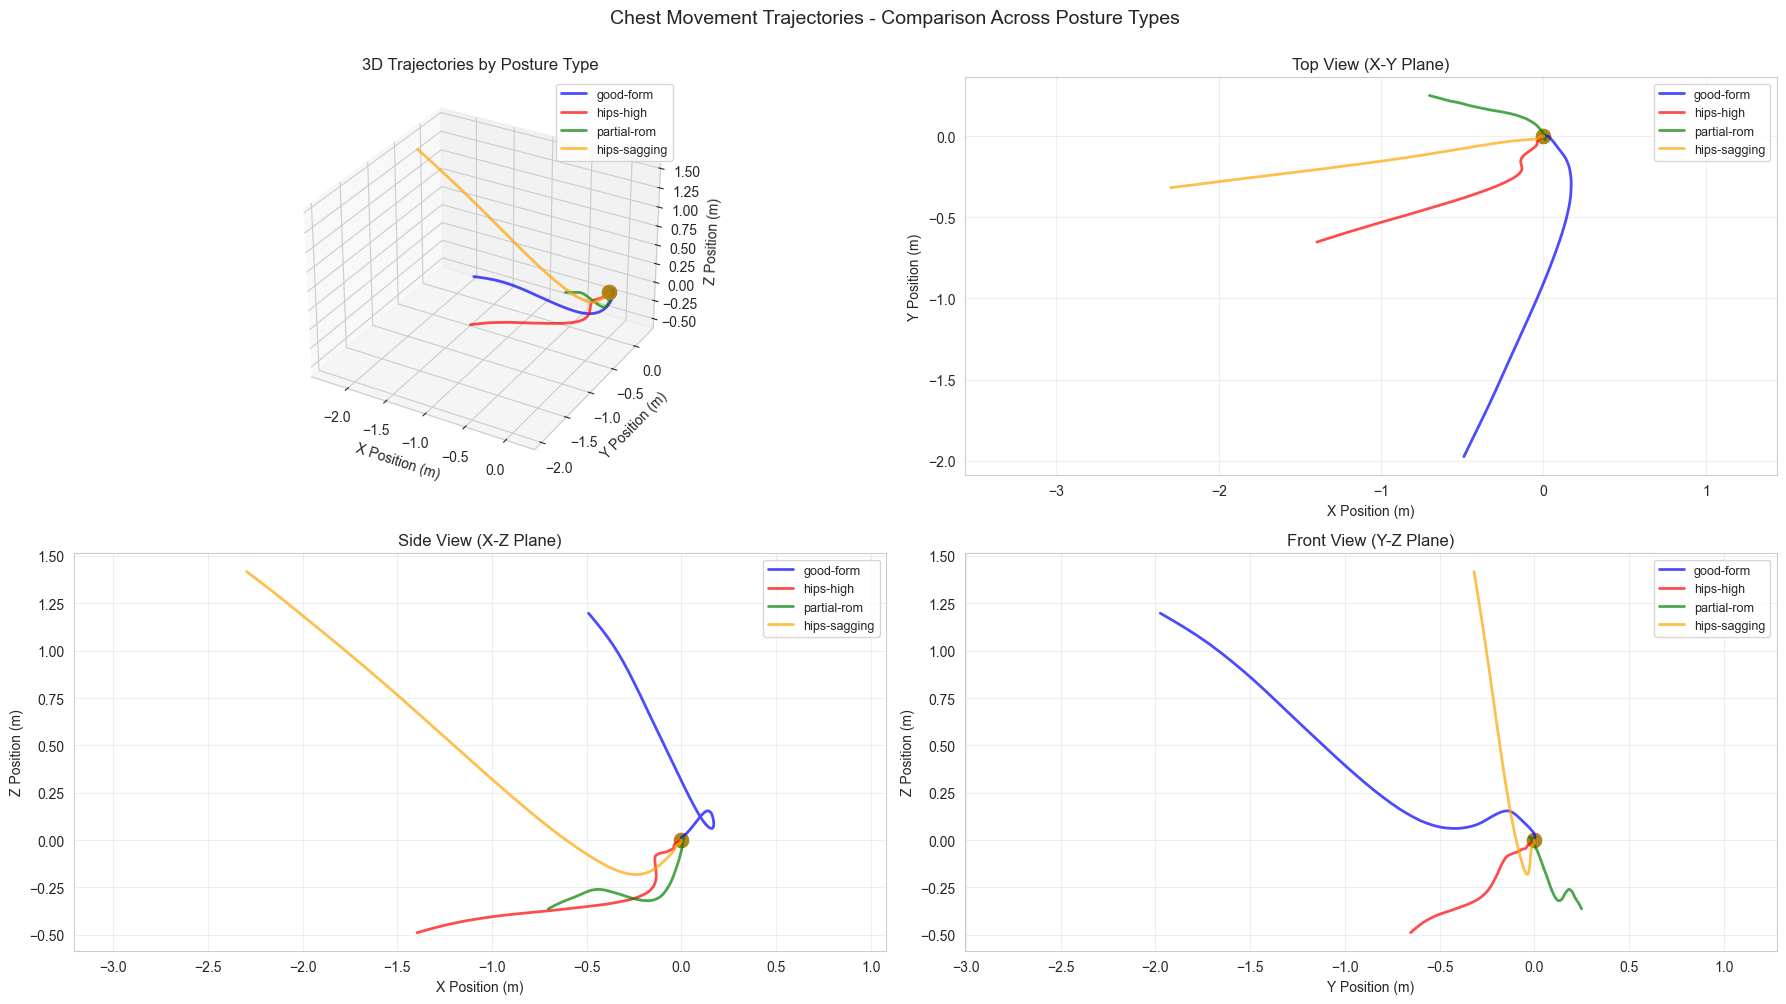


Note: All trajectories start at origin (0, 0, 0). Drift is expected due to IMU integration errors.


In [57]:
# Select one session from each posture type
posture_types = df['posture_label'].unique()
sessions_to_plot = []

for posture in posture_types:
    posture_sessions = df[df['posture_label'] == posture]['unique_session_id'].unique()
    if len(posture_sessions) > 0:
        sessions_to_plot.append((posture_sessions[0], posture))

# Create figure
fig = plt.figure(figsize=(18, 10))

# 3D plot
ax1 = fig.add_subplot(221, projection='3d')

colors = ['blue', 'red', 'green', 'orange', 'purple']
for idx, (session_id, posture) in enumerate(sessions_to_plot):
    session_data = df[df['unique_session_id'] == session_id].copy()
    session_data = session_data.sort_values('sample_index').reset_index(drop=True)
    
    result = integrate_position(session_data)
    
    ax1.plot(result['px'], result['py'], result['pz'], 
            color=colors[idx % len(colors)], alpha=0.7, linewidth=2, 
            label=f'{posture}')
    ax1.scatter([0], [0], [0], color=colors[idx % len(colors)], 
               s=100, marker='o', alpha=0.5)

ax1.set_xlabel('X Position (m)')
ax1.set_ylabel('Y Position (m)')
ax1.set_zlabel('Z Position (m)')
ax1.set_title('3D Trajectories by Posture Type')
ax1.legend(fontsize=9)

# Top view (X-Y)
ax2 = fig.add_subplot(222)
for idx, (session_id, posture) in enumerate(sessions_to_plot):
    session_data = df[df['unique_session_id'] == session_id].copy()
    session_data = session_data.sort_values('sample_index').reset_index(drop=True)
    
    result = integrate_position(session_data)
    
    ax2.plot(result['px'], result['py'], 
            color=colors[idx % len(colors)], alpha=0.7, linewidth=2, 
            label=f'{posture}')
    ax2.scatter([0], [0], color=colors[idx % len(colors)], 
               s=100, marker='o', alpha=0.5)

ax2.set_xlabel('X Position (m)')
ax2.set_ylabel('Y Position (m)')
ax2.set_title('Top View (X-Y Plane)')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')
ax2.legend(fontsize=9)

# Side view (X-Z)
ax3 = fig.add_subplot(223)
for idx, (session_id, posture) in enumerate(sessions_to_plot):
    session_data = df[df['unique_session_id'] == session_id].copy()
    session_data = session_data.sort_values('sample_index').reset_index(drop=True)
    
    result = integrate_position(session_data)
    
    ax3.plot(result['px'], result['pz'], 
            color=colors[idx % len(colors)], alpha=0.7, linewidth=2, 
            label=f'{posture}')
    ax3.scatter([0], [0], color=colors[idx % len(colors)], 
               s=100, marker='o', alpha=0.5)

ax3.set_xlabel('X Position (m)')
ax3.set_ylabel('Z Position (m)')
ax3.set_title('Side View (X-Z Plane)')
ax3.grid(True, alpha=0.3)
ax3.axis('equal')
ax3.legend(fontsize=9)

# Front view (Y-Z)
ax4 = fig.add_subplot(224)
for idx, (session_id, posture) in enumerate(sessions_to_plot):
    session_data = df[df['unique_session_id'] == session_id].copy()
    session_data = session_data.sort_values('sample_index').reset_index(drop=True)
    
    result = integrate_position(session_data)
    
    ax4.plot(result['py'], result['pz'], 
            color=colors[idx % len(colors)], alpha=0.7, linewidth=2, 
            label=f'{posture}')
    ax4.scatter([0], [0], color=colors[idx % len(colors)], 
               s=100, marker='o', alpha=0.5)

ax4.set_xlabel('Y Position (m)')
ax4.set_ylabel('Z Position (m)')
ax4.set_title('Front View (Y-Z Plane)')
ax4.grid(True, alpha=0.3)
ax4.axis('equal')
ax4.legend(fontsize=9)

plt.suptitle('Chest Movement Trajectories - Comparison Across Posture Types', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\nNote: All trajectories start at origin (0, 0, 0). Drift is expected due to IMU integration errors.")

## Z Direction Integration

In [58]:
def integrate_position_z(df_session, sample_rate=40.0, grav_z_g=-1.0):
    """
    Calculates the Z-position by double integration of Z-acceleration,
    correcting for gravity offset based on the known IMU orientation (Z-down).

    Args:
        df_session (pd.DataFrame): DataFrame containing 'az' and 'sample_index'.
        sample_rate (float): Sampling frequency in Hz.
        grav_z_g (float): Expected gravity component along the Z-axis (in g).

    Returns:
        pd.DataFrame: Original DataFrame with 'vz' (velocity) and 'pz' (position) columns added.
    """
    import numpy as np
    
    dt = 1.0 / sample_rate
    # Convert acceleration from g to m/s^2 (assume 9.81 m/s^2)
    accel_g_to_ms2 = 9.81
    az_raw = df_session['az'].values * accel_g_to_ms2

    # 1. Correct for gravity bias
    # If Z is pointing down, stationary 'az' is -1g. The true movement acceleration (amove) is: amove = araw - agravity
    az_corrected = az_raw - (grav_z_g * accel_g_to_ms2)

    # Simple zero-setting on corrected acceleration's mean for minor drift removal
    az_corrected -= np.mean(az_corrected)

    # 2. First Integration (Velocity)
    vz = np.cumsum(az_corrected * dt)

    # Apply velocity drift correction (Assume velocity starts and ends at zero for the entire pushup set)
    vz -= np.linspace(vz[0], vz[-1], len(vz))

    # 3. Second Integration (Position)
    pz = np.cumsum(vz * dt)

    # Final position drift correction (zero-reset at ends)
    pz -= np.linspace(pz[0], pz[-1], len(pz))

    df_session['vz'] = vz
    df_session['pz'] = pz
    return df_session

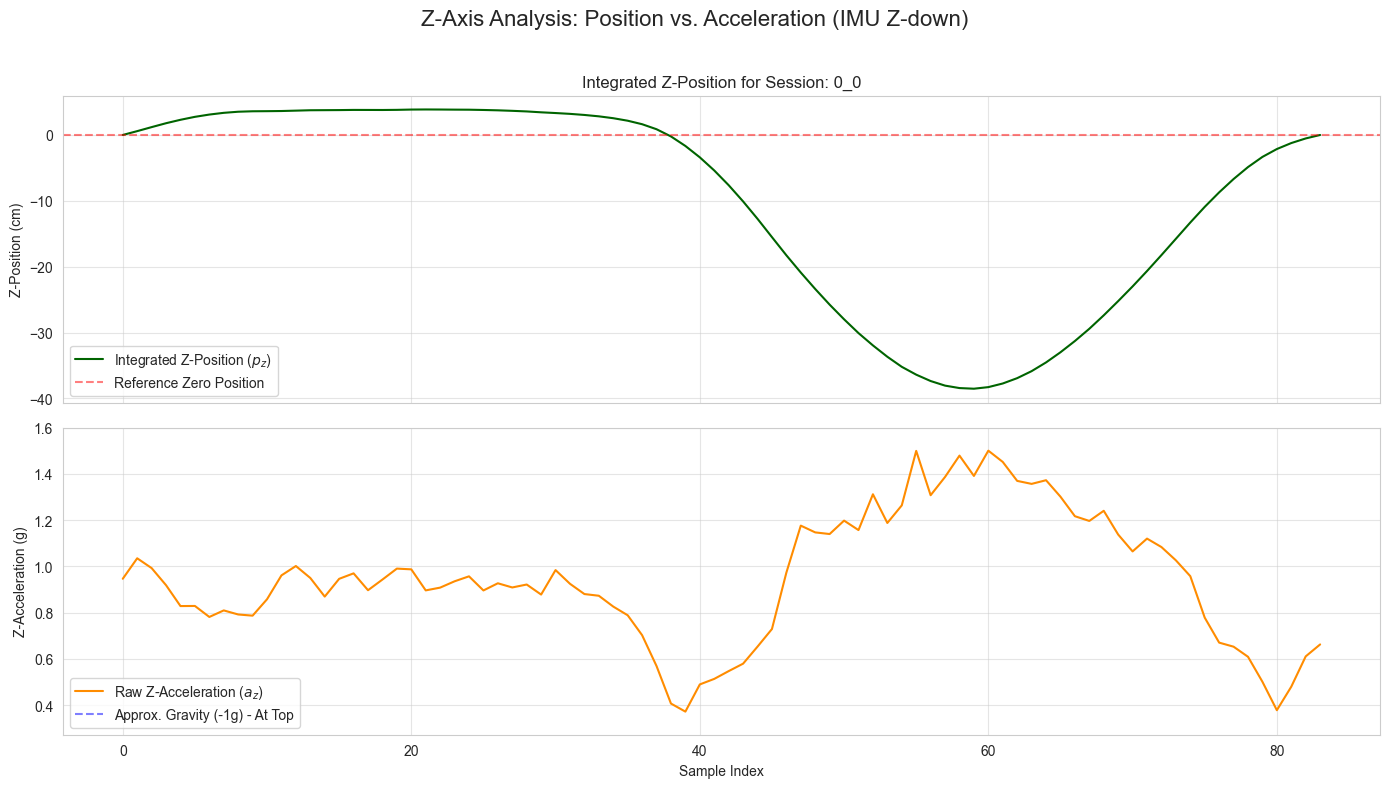


Note on Interpretation:
 - The lowest point on the Z-Position plot ($p_z$) corresponds to the chest being fully extended (AT-TOP).
 - The highest point on the Z-Position plot ($p_z$) corresponds to the chest being closest to the floor (AT-BOTTOM).
 - The raw Z-Acceleration ($a_z$) should be approximately -1.0g at the AT-TOP phase.
 - The raw Z-Acceleration ($a_z$) should be less negative (closer to 0) at the AT-BOTTOM phase.


In [64]:
# Assuming a full DataFrame 'df' containing all session data is loaded in a previous step.
# Select the first unique session ID for visualization.
import matplotlib.pyplot as plt

if 'unique_session_id' in df.columns:
    session_id_to_plot = df['unique_session_id'].unique()[0]
    session_data = df[df['unique_session_id'] == session_id_to_plot].sort_values('sample_index').reset_index(drop=True)

    # Run the integration
    session_data = integrate_position_z(session_data)

    # --- Plotting the Z-Position and Raw Z-Acceleration ---
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    sample_indices = session_data['sample_index']

    # 1. Z-Position Plot
    # Multiply by 100 to plot in centimeters
    axes[0].plot(sample_indices, session_data['pz'] * 100, label='Integrated Z-Position ($p_z$)', color='darkgreen')
    axes[0].set_ylabel('Z-Position (cm)')
    axes[0].set_title(f'Integrated Z-Position for Session: {session_id_to_plot}')
    axes[0].axhline(0, color='red', linestyle='--', alpha=0.5, label='Reference Zero Position')
    axes[0].legend(loc='lower left')
    axes[0].grid(True, alpha=0.5)

    # 2. Raw Z-Acceleration Plot
    axes[1].plot(sample_indices, session_data['az'], label='Raw Z-Acceleration ($a_z$)', color='darkorange')
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Z-Acceleration (g)')
    axes[1].axhline(-1.0, color='blue', linestyle='--', alpha=0.5, label='Approx. Gravity (-1g) - At Top')
    axes[1].legend(loc='lower left')
    axes[1].grid(True, alpha=0.5)
    axes[1].set_ylim(session_data['az'].min() - 0.1, session_data['az'].max() + 0.1)

    plt.suptitle('Z-Axis Analysis: Position vs. Acceleration (IMU Z-down)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()

    print("\nNote on Interpretation:")
    print(" - The lowest point on the Z-Position plot ($p_z$) corresponds to the chest being fully extended (AT-TOP).")
    print(" - The highest point on the Z-Position plot ($p_z$) corresponds to the chest being closest to the floor (AT-BOTTOM).")
    print(" - The raw Z-Acceleration ($a_z$) should be approximately -1.0g at the AT-TOP phase.")
    print(" - The raw Z-Acceleration ($a_z$) should be less negative (closer to 0) at the AT-BOTTOM phase.")
else:
    print("Error: The DataFrame 'df' does not contain 'unique_session_id'. Ensure your data loading step is complete.")